In [5]:
# Data preprocessing & model building, data for prediction and metrices

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, hour, col, lit, dayofweek, weekofyear
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# 1. Start Spark session
spark = SparkSession.builder.appName("BirdSpeciesPresenceByTime").getOrCreate()

# 2. Load the JSON data
df_raw = spark.read.option("multiline", "true").json("birdsdetection11Tage_backup.json")

# 3. Extract time-based features and species
df = df_raw.withColumn("timestamp", to_timestamp("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("week", weekofyear("timestamp")) \
    .withColumn("speciesId", col("species.id")) \
    .withColumn("speciesName", col("species.commonName"))

# 4. Get unique hours to create negative samples
time_combinations = df.select("hour", "day_of_week", "week").distinct()

# 5. Get all distinct species
species_list = df.select("speciesId", "speciesName").distinct().collect()

# Processed Data
processed_data = []

# Dictionaries to store metrics for each model (across species, you can later average or inspect per species)
model_metrics = {"Logistic Regression": [], "Random Forest": [], "SVM": []}
model_results = {"Logistic Regression": [], "Random Forest": [], "SVM": []}

for row in species_list:
    species_id = row["speciesId"]
    species_name = row["speciesName"]
    
    # Positive samples for this species
    df_pos_raw = df.filter(col("speciesId") == species_id) \
                   .select("hour", "day_of_week", "week") \
                   .distinct()
    
    # Negative samples = time slots where this species was NOT seen
    df_neg = time_combinations.subtract(df_pos_raw)

    # Add labels: 1 for positive samples, 0 for negative samples
    df_pos = df_pos_raw.withColumn("label", lit(1))
    df_neg = df_neg.withColumn("label", lit(0))
    
    # Combine positive and negative samples
    df_model = df_pos.union(df_neg)
    
    # Assemble features (you can also add day_of_week and week as features)
    assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
    df_model = assembler.transform(df_model)
    processed_data.append((species_name, df_model.select("hour", "label")))
    
    # **Split into train and test sets**
    train, test = df_model.randomSplit([0.7, 0.3], seed=42)
    
    # --- Logistic Regression ---
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    lr_model = lr.fit(train)
    lr_predictions = lr_model.transform(test)
    
    # --- Random Forest Classifier ---
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
    rf_model = rf.fit(train)
    rf_predictions = rf_model.transform(test)
    
    # --- Support Vector Machine (LinearSVC) ---
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)
    svm_model = svm.fit(train)
    svm_predictions = svm_model.transform(test)

    # Store predictions
    model_results["Logistic Regression"].append((species_name, lr_predictions))
    model_results["Random Forest"].append((species_name, rf_predictions))
    model_results["SVM"].append((species_name, svm_predictions))
    
    # Evaluate using common metrics
    # For Logistic Regression and Random Forest, we can compute AUC since probability estimates are available.
    auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    
    # Logistic Regression metrics
    lr_auc = auc_evaluator.evaluate(lr_predictions)
    lr_acc = acc_evaluator.evaluate(lr_predictions)
    lr_f1 = f1_evaluator.evaluate(lr_predictions)
    
    # Random Forest metrics
    rf_auc = auc_evaluator.evaluate(rf_predictions)
    rf_acc = acc_evaluator.evaluate(rf_predictions)
    rf_f1 = f1_evaluator.evaluate(rf_predictions)
    
    # For SVM, since there is no probability column, we skip AUC and only compute accuracy and F1.
    svm_acc = acc_evaluator.evaluate(svm_predictions)
    svm_f1 = f1_evaluator.evaluate(svm_predictions)
    
    # Store metrics
    model_metrics["Logistic Regression"].append({"species": species_name, "accuracy": lr_acc, "f1": lr_f1, "auc": lr_auc})
    model_metrics["Random Forest"].append({"species": species_name, "accuracy": rf_acc, "f1": rf_f1, "auc": rf_auc})
    model_metrics["SVM"].append({"species": species_name, "accuracy": svm_acc, "f1": svm_f1})
    
    print(f"✅ Trained and evaluated models for {species_name}")

✅ Trained and evaluated models for Crested Tit
✅ Trained and evaluated models for Rook
✅ Trained and evaluated models for Reed Bunting
✅ Trained and evaluated models for Stock Dove
✅ Trained and evaluated models for Yellowhammer
✅ Trained and evaluated models for Eurasian Siskin
✅ Trained and evaluated models for Eurasian Moorhen
✅ Trained and evaluated models for Common Sandpiper
✅ Trained and evaluated models for Eurasian Magpie
✅ Trained and evaluated models for Gray Heron
✅ Trained and evaluated models for Common Wood-Pigeon
✅ Trained and evaluated models for Common Buzzard
✅ Trained and evaluated models for Eurasian Tree Sparrow
✅ Trained and evaluated models for Eurasian Kestrel
✅ Trained and evaluated models for Short-toed Treecreeper
✅ Trained and evaluated models for Eurasian Jay
✅ Trained and evaluated models for Hawfinch
✅ Trained and evaluated models for Water Rail
✅ Trained and evaluated models for Rock Pigeon
✅ Trained and evaluated models for Mistle Thrush
✅ Trained and 

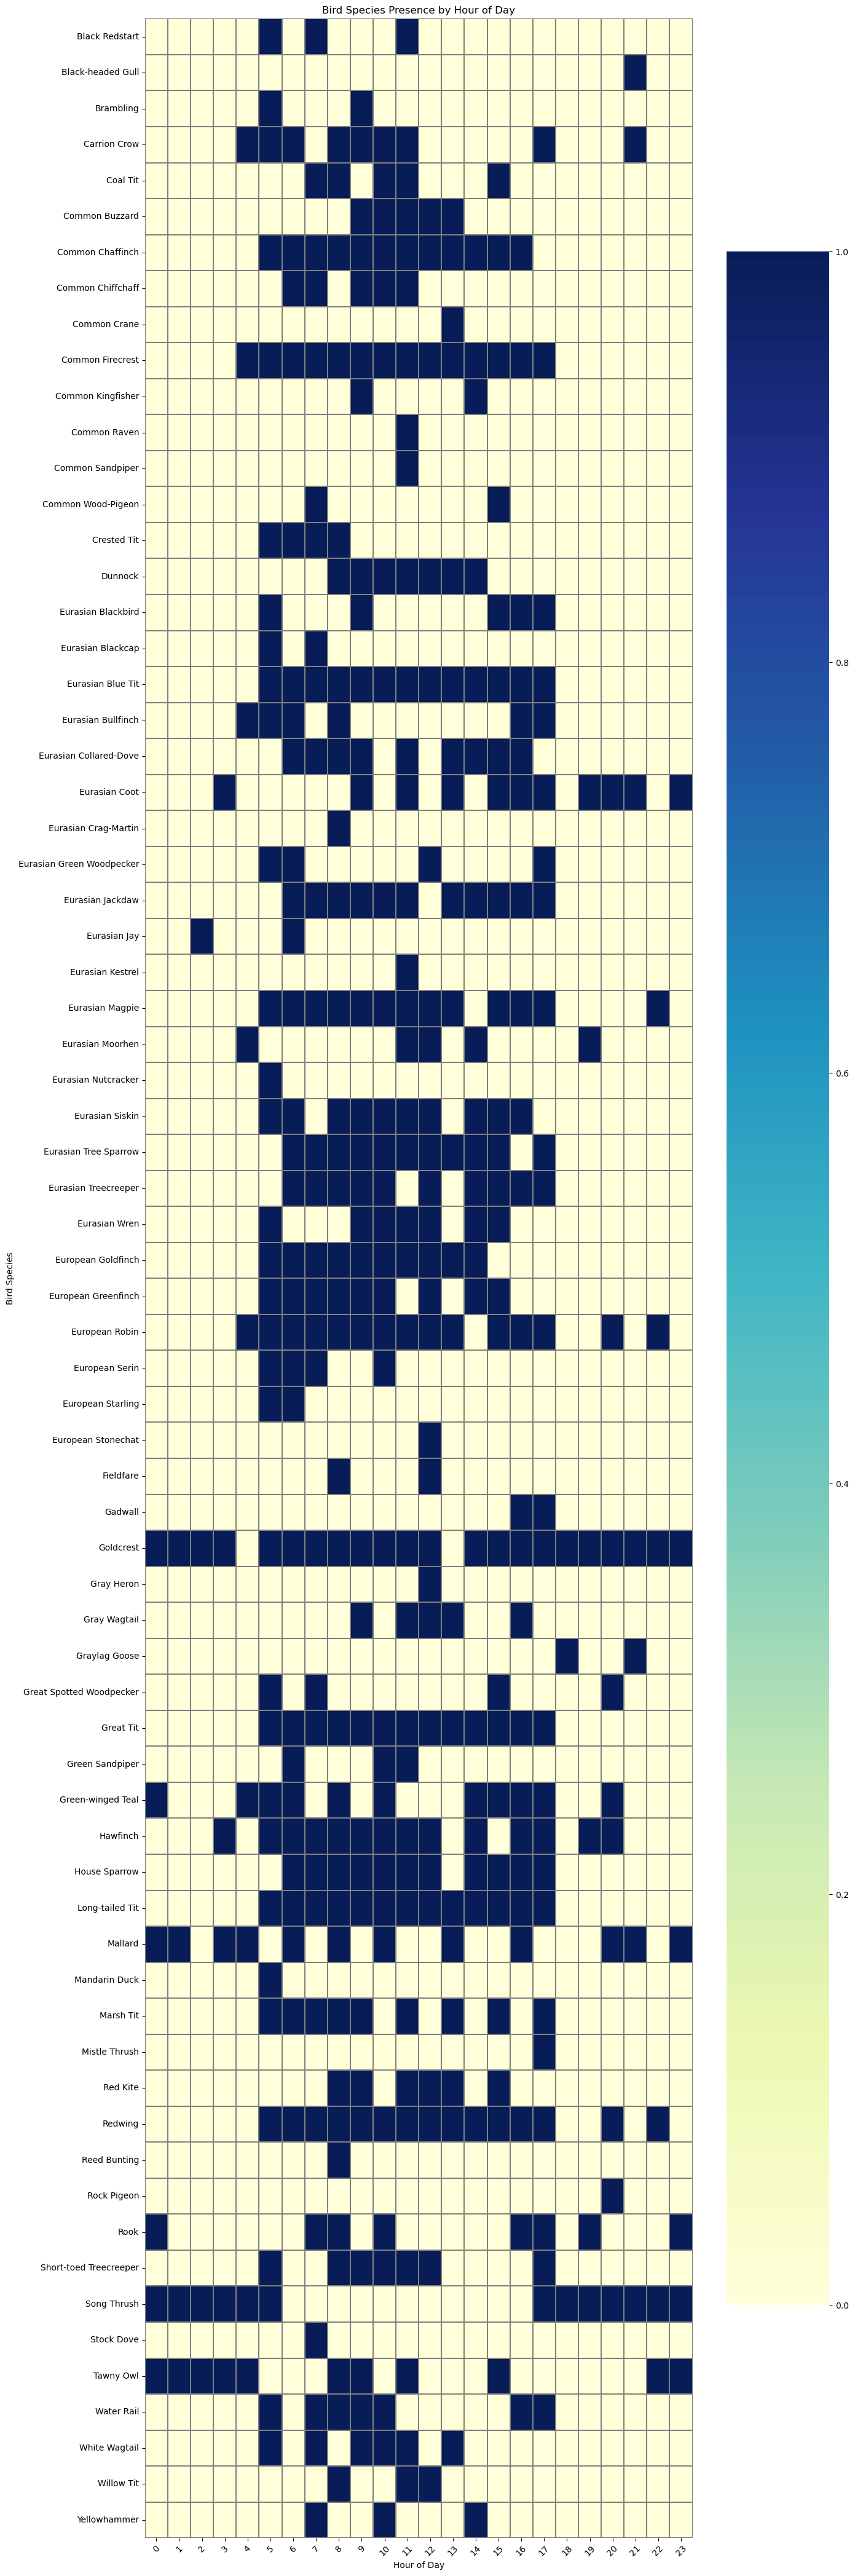

In [9]:
# INSPECT DATA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions into a single Pandas DataFrame
all_data = []

for species_name, data_df in processed_data:
    # Get only hour and prediction columns
    pd_df = data_df.select("hour", "label").toPandas()
    pd_df["species"] = species_name
    all_data.append(pd_df)

# Combine into one DataFrame
preds_df = pd.concat(all_data)

# Pivot to make heatmap table: rows = species, columns = hours
heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="label", aggfunc="max").fillna(0)

# Plot heatmap
plt.figure(figsize=(14, len(heatmap_data) * 0.6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')

plt.title("Bird Species Presence by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bird Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

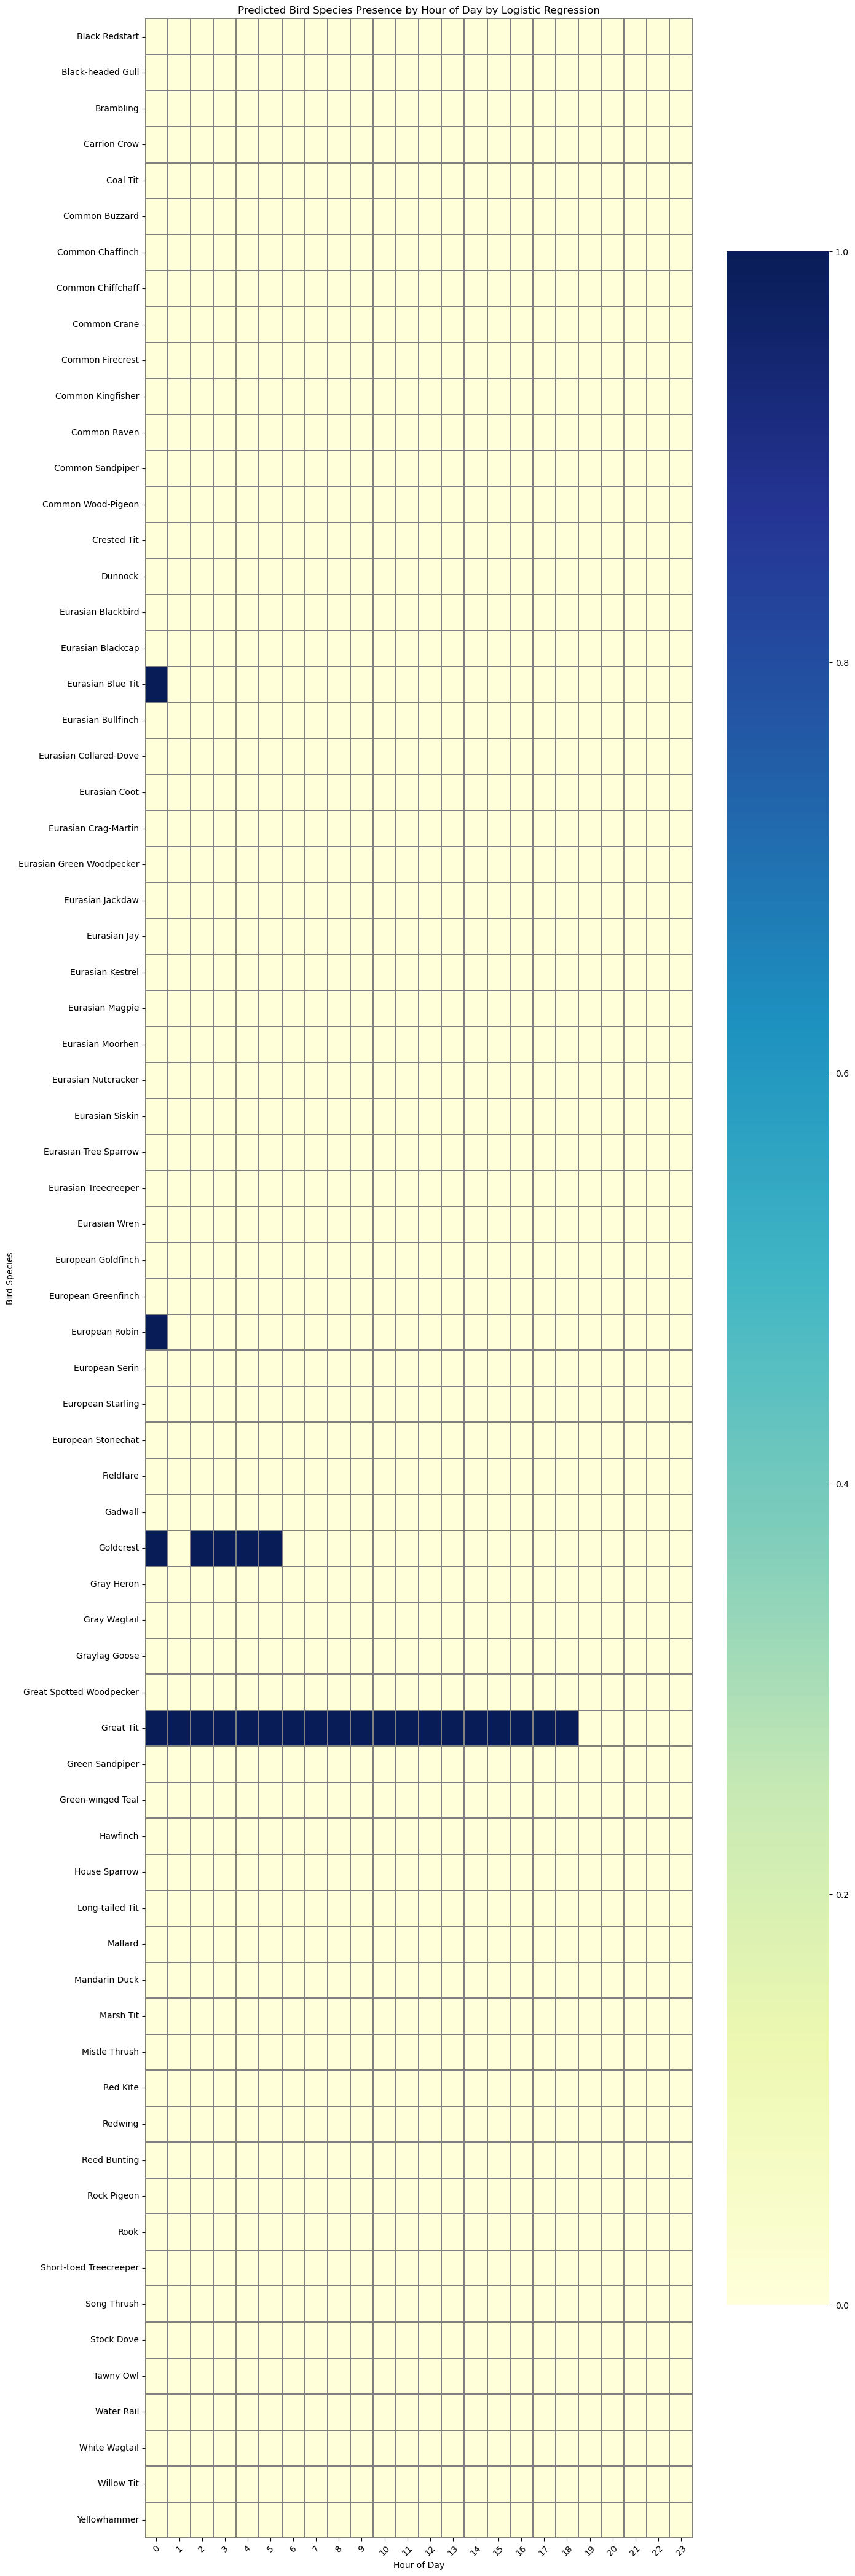

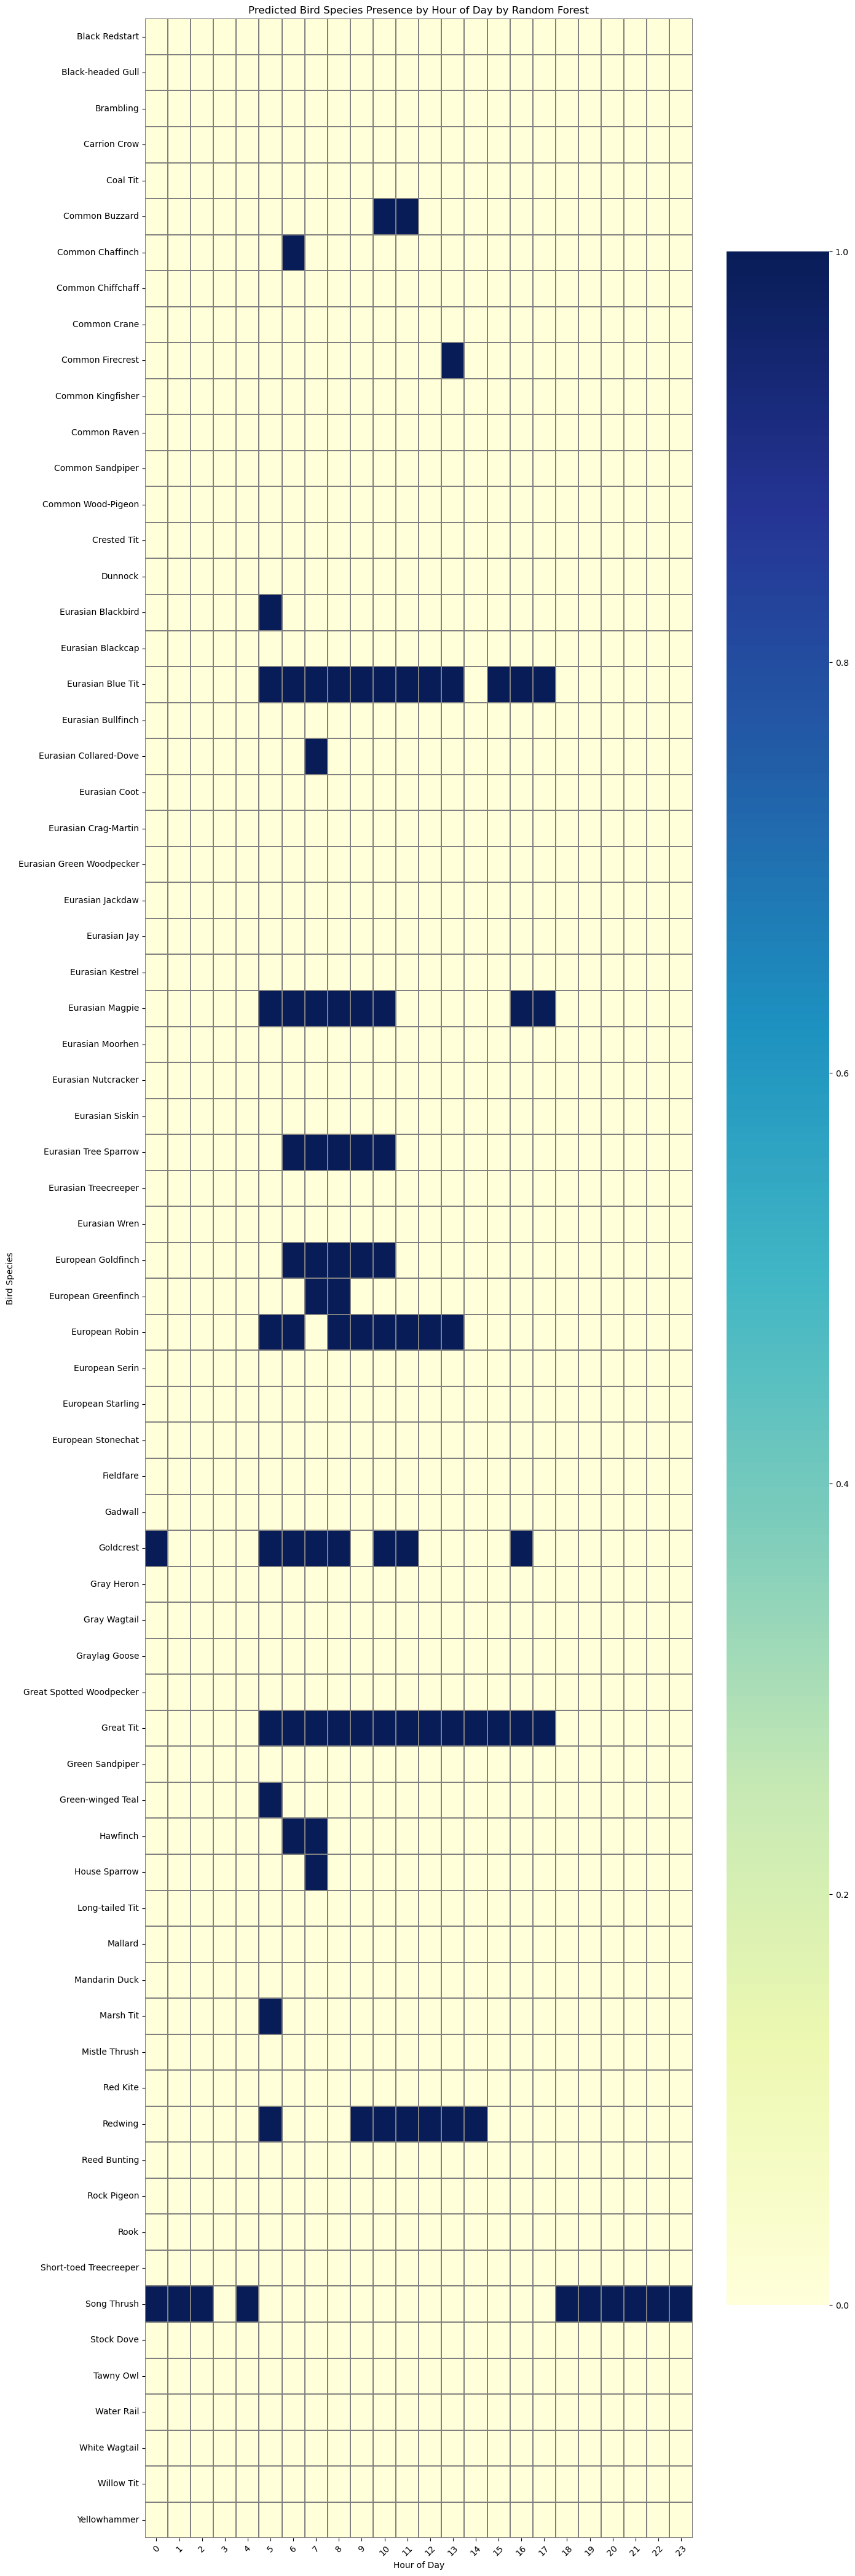

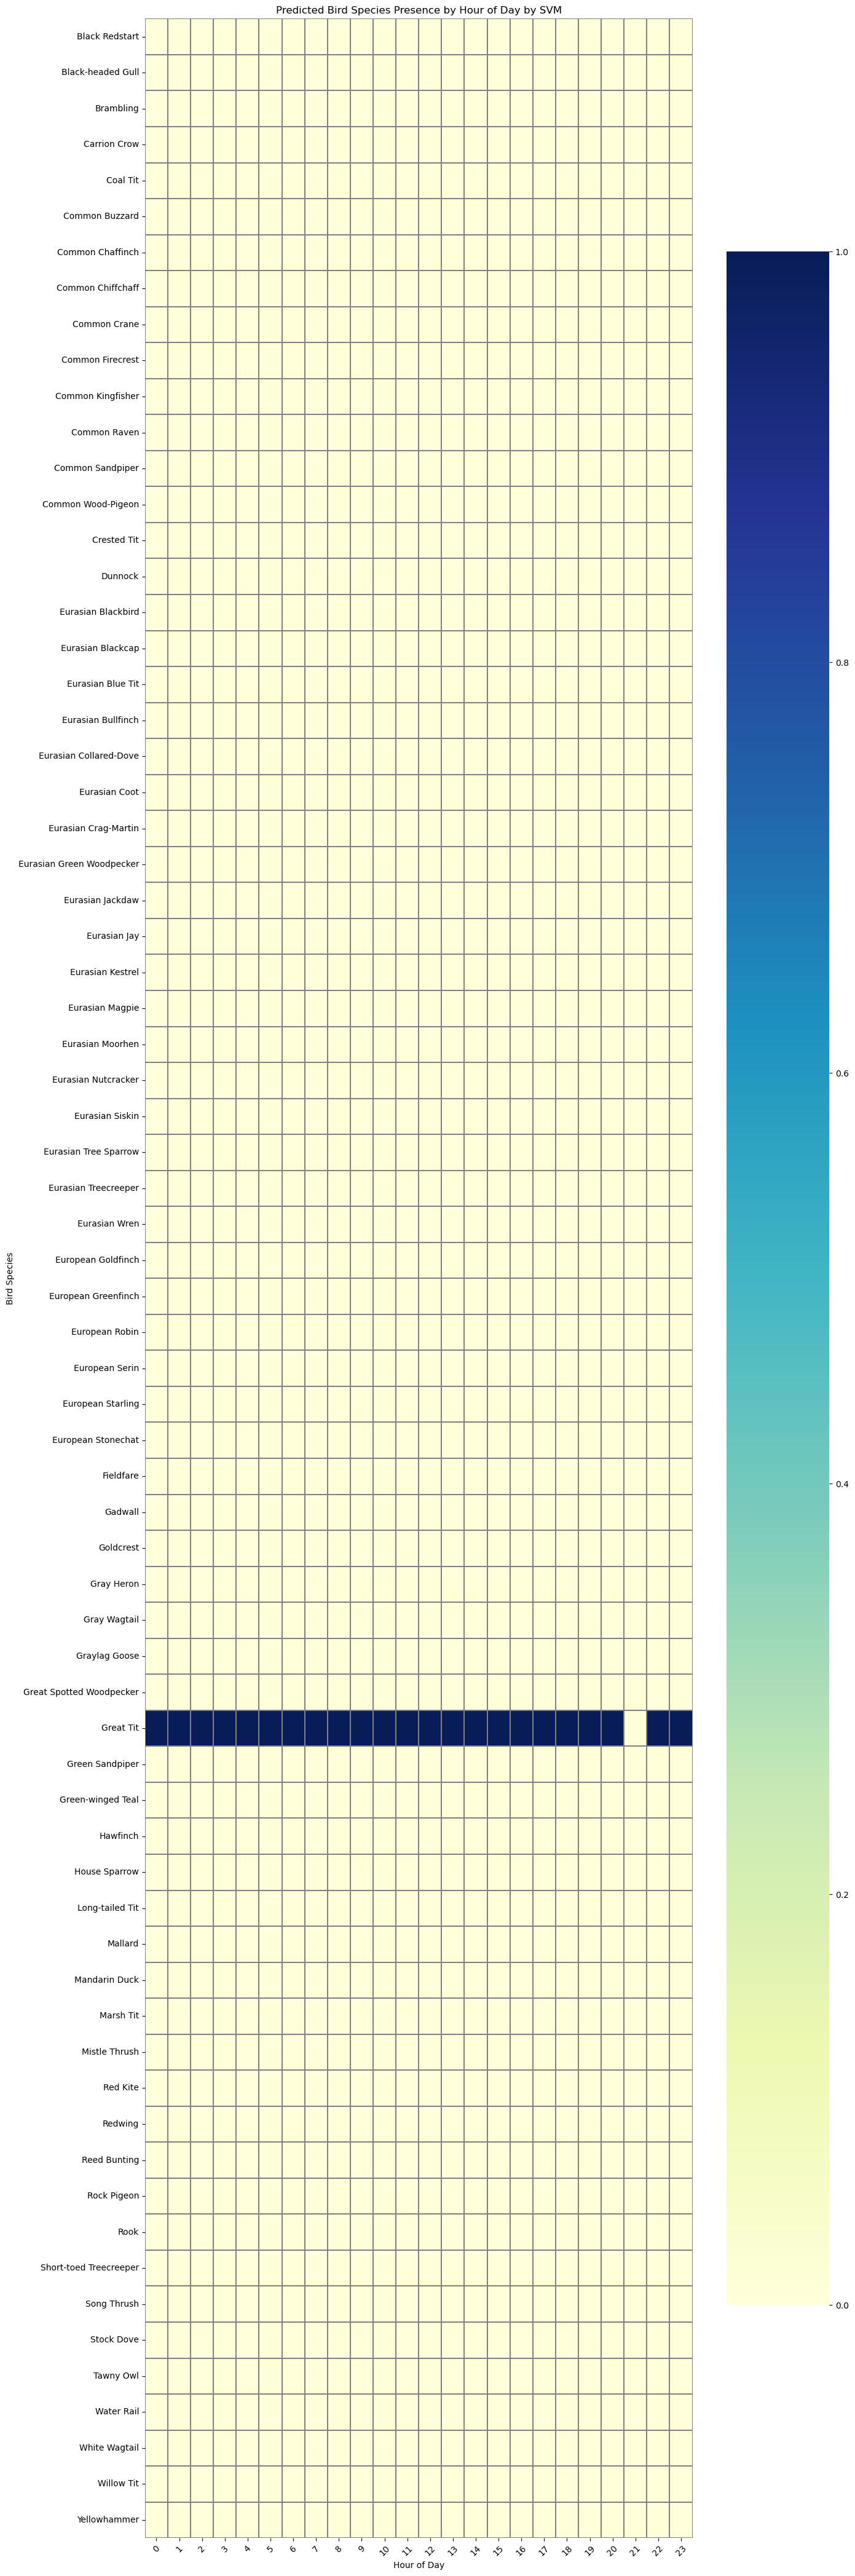

In [7]:
# INSPECT PREDICTIONS

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot(label: str):
    all_preds = []
    for species_name, predictions_df in model_results[label]:
        # Get only hour and prediction columns
        pd_df = predictions_df.select("hour", "prediction").toPandas()
        pd_df["species"] = species_name
        all_preds.append(pd_df)
    
    # Combine into one DataFrame
    preds_df = pd.concat(all_preds)
    
    # Pivot to make heatmap table: rows = species, columns = hours
    heatmap_data = preds_df.pivot_table(index="species", columns="hour", values="prediction", aggfunc="max").fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(14, len(heatmap_data) * 0.6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, linewidths=0.3, linecolor='gray')
    
    plt.title("Predicted Bird Species Presence by Hour of Day by " + label)
    plt.xlabel("Hour of Day")
    plt.ylabel("Bird Species")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# model_results = {"Logistic Regression": [], "Random Forest": [], "SVM": []}
plot("Logistic Regression")
plot("Random Forest")
plot("SVM")


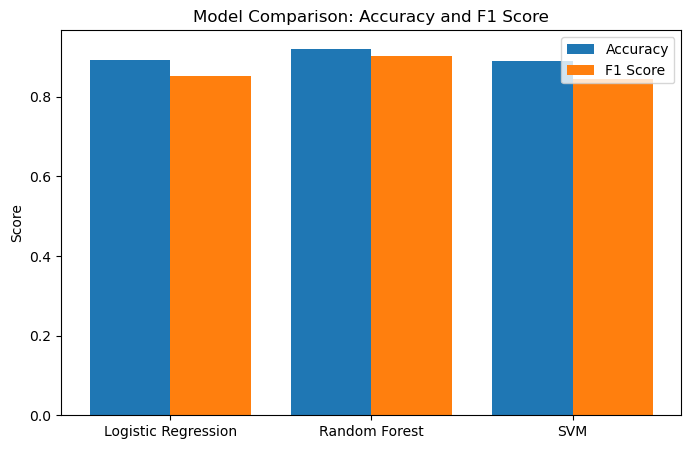

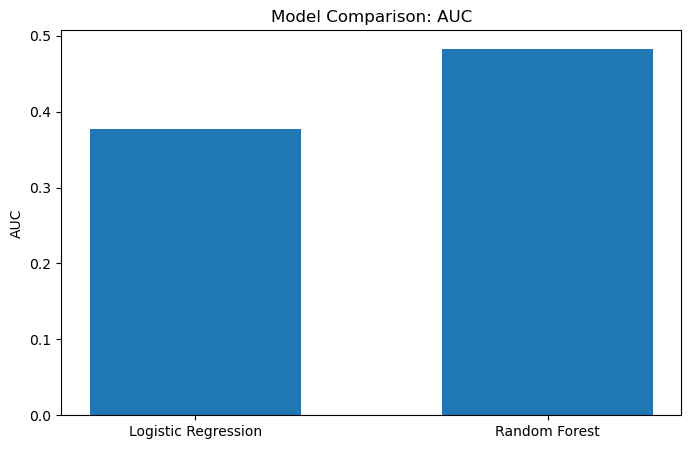

In [10]:
# METRICES

# For plotting, let's average the metrics across species.
def average_metric(metrics_list, key):
    return sum(m[key] for m in metrics_list) / len(metrics_list)

models = []
accuracies = []
f1_scores = []
aucs = []  # only for models that provide AUC

for model_name, metrics in model_metrics.items():
    models.append(model_name)
    accuracies.append(average_metric(metrics, "accuracy"))
    f1_scores.append(average_metric(metrics, "f1"))
    # For AUC, only add if the metric exists (SVM does not have AUC)
    if "auc" in metrics[0]:
        aucs.append(average_metric(metrics, "auc"))
    else:
        aucs.append(0)

# Plot Accuracy and F1 Score
plt.figure(figsize=(8,5))
x = range(len(models))
plt.bar(x, accuracies, width=0.4, label="Accuracy", align='center')
plt.bar([p + 0.4 for p in x], f1_scores, width=0.4, label="F1 Score", align='center')
plt.xticks([p + 0.2 for p in x], models)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy and F1 Score")
plt.legend()
plt.show()

# Plot AUC for models that provide it (skip SVM if needed)
plt.figure(figsize=(8,5))
auc_models = [model for model in models if model != "SVM"]
auc_values = [auc for model, auc in zip(models, aucs) if model != "SVM"]
plt.bar(auc_models, auc_values, width=0.6)
plt.ylabel("AUC")
plt.title("Model Comparison: AUC")
plt.show()